In [49]:
import os
import json
import gzip
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

from urllib.request import urlopen
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import string

from IPython.display import Image
from sklearn.manifold import TSNE

In [50]:
rating_only = pd.read_csv('Pet_Supplies.csv', names=['item','user','rating','timestamp'])

In [54]:
rating_only

,item,user,rating,timestamp
0,0972585419,A13K4OZKAAHOXS,3.0,1190851200
1,0972585419,A1DWYEX4P7GB7Z,4.0,1188000000
2,0972585419,A3NVN97YJSKEPC,4.0,1171929600
3,0972585419,A1PDMES1LYA0DP,1.0,1483056000
4,0972585419,AT6BH0TQLZS5X,1.0,1482451200
...,...,...,...,...
6542478,B01HJDIJQ2,A26N76ZOU621RL,5.0,1498003200
6542479,B01HJDIJQ2,A1GRVX5Y1L702P,5.0,1494201600
6542480,B01HJDIJQ2,A2OQBT92X1CZ6D,4.0,1485820800
6542481,B01HJDIJQ2,A2O6GB287JBIGP,5.0,1483315200


# Product reviews

In [51]:
#get count of each star reviews for for each product
product_1 = rating_only[rating_only['rating']<1.4][['item','rating']].groupby('item').count().rename(columns={'rating':'1count'})
product_2 = rating_only[(rating_only['rating']<2.4) & (rating_only['rating']>1.4)][['item','rating']].groupby('item').count().rename(columns={'rating':'2count'})
product_3 = rating_only[(rating_only['rating']<3.4) & (rating_only['rating']>2.4)].groupby('item').count().rename(columns={'rating':'3count'})
product_4 = rating_only[(rating_only['rating']<4.6) & (rating_only['rating']>3.4)][['item','rating']].groupby('item').count().rename(columns={'rating':'4count'})
product_5 = rating_only[rating_only['rating']==5.0][['item','rating']].groupby('item').count().rename(columns={'rating':'5count'})
product_count =rating_only[['item','rating']].groupby('item').count().rename(columns={'rating':'count'})

In [52]:
#get mean, max, min, std, and list of columns to include in the new datafrmae
product_mean = rating_only[['item','rating']].groupby('item').mean().rename(columns={'rating':'mean'})
product_max = rating_only[['item','rating']].groupby('item').max().rename(columns={'rating':'max'})
product_min = rating_only[['item','rating']].groupby('item').min().rename(columns={'rating':'min'})
product_std =rating_only[['item','rating']].groupby('item').std().rename(columns={'rating':'std'})
df_products = [product_1, product_2, product_3, product_4, product_5, product_count, product_mean, product_max, product_min, product_std]

In [53]:
#transform to percentages
items = pd.concat(df_products, join='outer', axis=1).fillna(0)
items['percent1'] = items['1count']/items['count']
items['percent2'] = items['2count']/items['count']
items['percent3'] = items['3count']/items['count']
items['percent4'] = items['4count']/items['count']
items['percent5'] = items['5count']/items['count']
items['count_log'] = np.log(items['count'])
items_perc = items[['percent1','percent2','percent3','percent4','percent5','mean','max','min','std','count']]#,'count_log']]
normalized_items=(items_perc - items_perc.mean())/items_perc.std()

In [7]:
items_perc

,percent1,percent2,percent3,percent4,percent5,mean,max,min,std,count
item,,,,,,,,,,
0615553605,0.111111,0.000000,0.111111,0.222222,0.555556,4.111111,5.0,1.0,1.364225,9
0760339597,0.111111,0.000000,0.111111,0.111111,0.666667,4.222222,5.0,1.0,1.394433,9
0972585419,0.317460,0.063492,0.190476,0.142857,0.285714,3.015873,5.0,1.0,1.631268,63
0975412868,0.100000,0.100000,0.000000,0.100000,0.700000,4.200000,5.0,1.0,1.475730,10
0982393555,0.500000,0.000000,0.000000,0.000000,0.500000,3.000000,5.0,1.0,2.309401,4
...,...,...,...,...,...,...,...,...,...,...
B01HIXW7RA,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,5.0,5.0,0.000000,1
B01HIYHX6E,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,5.0,5.0,0.000000,1
B01HIZVYCM,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,5.0,5.0,0.000000,1


In [8]:
normalized_items.head()

,percent1,percent2,percent3,percent4,percent5,mean,max,min,std,count
item,,,,,,,,,,
0615553605,-0.048773,-0.375181,0.112294,0.419226,-0.115390,0.094512,0.402839,-1.046093,0.789312,-0.112740
0760339597,-0.048773,-0.375181,0.112294,-0.069327,0.195092,0.198572,0.402839,-1.046093,0.828391,-0.112740
0972585419,0.808979,-0.006971,0.510565,0.070260,-0.869417,-0.931220,0.402839,-1.046093,1.134778,0.141180
0975412868,-0.094960,0.204750,-0.445285,-0.118182,0.288237,0.177760,0.402839,-1.046093,0.933562,-0.108038
0982393555,1.567760,-0.375181,-0.445285,-0.557880,-0.270631,-0.946086,0.402839,-1.046093,2.012062,-0.136251


Text(0, 0.5, 'SSE')

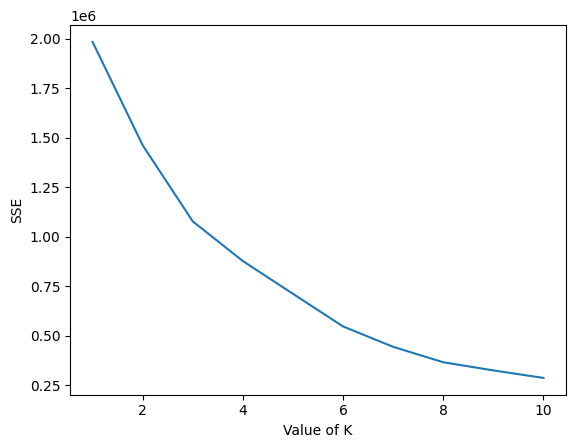

In [9]:
SSE = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state = 42)
  kmeans.fit(normalized_items) 
  labels = kmeans.labels_
  score = kmeans.inertia_ #This is the SSE value
  SSE.append(score)
plt.plot(range(1,11), SSE)
plt.xlabel('Value of K')
plt.ylabel('SSE')

In [6]:
from sklearn.manifold import TSNE

# Lets dim reduce the 10 dimension vectors to 2 dimensions to vizualise the dataset 
data_embed = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(items_perc) #normalized_items)

/opt/anaconda3/envs/phd/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/phd/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 198402 samples in 0.175s...
[t-SNE] Computed neighbors for 198402 samples in 25.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 198402
[t-SNE] Computed conditional probabilities for sample 2000 / 198402
[t-SNE] Computed conditional probabilities for sample 3000 / 198402
[t-SNE] Computed conditional probabilities for sample 4000 / 198402
[t-SNE] Computed conditional probabilities for sample 5000 / 198402
[t-SNE] Computed conditional probabilities for sample 6000 / 198402
[t-SNE] Computed conditional probabilities for sample 7000 / 198402
[t-SNE] Computed conditional probabilities for sample 8000 / 198402
[t-SNE] Computed conditional probabilities for sample 9000 / 198402
[t-SNE] Computed conditional probabilities for sample 10000 / 198402
[t-SNE] Computed conditional probabilities for sample 11000 / 198402
[t-SNE] Computed conditional probabilities for sample 12000 / 198402
[t-SNE] Computed conditional proba

In [7]:
#Used elbow method to choose number of cluster to be 6
kmeans = KMeans(n_clusters=6, random_state=42)
X = np.array(normalized_items)
kmeans.fit(X)
kmeans.labels_

df_item = pd.DataFrame(data_embed[:,:2],columns=["x","y"])
df_item['Feature 1'] = items_perc.index
df_item['Feature 2'] = kmeans.labels_
df_item.head()
df_item.to_csv('DMA_rating_percent/DMA_final_cluster_items_percent.csv', sep=',', index=False)

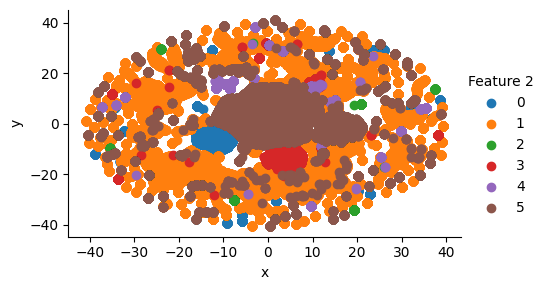

In [8]:
fg = sns.FacetGrid(data=df_item, hue='Feature 2', aspect=1.61)
fg.map(plt.scatter, 'x', 'y').add_legend()

In [10]:
print(kmeans.cluster_centers_)
print(normalized_items.columns)

[[-0.49941989 -0.35654895 -0.279144    2.91001933 -1.18639116  0.10719123
  -0.21216672  0.63023905 -0.56607282 -0.14640802]
 [ 0.12966401  0.10683949  0.07538354 -0.03004263 -0.16152789 -0.19035393
   0.37259325 -0.84612086  0.96070179  0.17041639]
 [-0.22256494  4.98011376 -0.42676164 -0.5447878  -1.66613957 -1.93682543
  -2.49020993 -0.54745929 -0.82114286 -0.14904233]
 [ 3.55863612 -0.3138461  -0.39641604 -0.5548861  -1.66763167 -2.78887925
  -3.39664615 -1.0460926  -0.90323226 -0.14834565]
 [-0.30079712 -0.19336016  4.07822852 -0.53356683 -1.63645584 -1.04381614
  -1.46469237 -0.0395936  -0.66851256 -0.1485835 ]
 [-0.5106378  -0.37399266 -0.41384536 -0.41216046  1.01585054  0.88364068
   0.40283935  1.14909102 -0.84996346 -0.13878038]]
Index(['percent1', 'percent2', 'percent3', 'percent4', 'percent5', 'mean',
       'max', 'min', 'std', 'count'],
      dtype='object')


In [11]:
df_item.groupby('Feature 2').count()

,x,y,Feature 1
Feature 2,,,
0,15173,15173,15173
1,90161,90161,90161
2,5332,5332,5332
3,9879,9879,9879
4,7981,7981,7981
5,69876,69876,69876


# User reviews

In [12]:
#get count of each star reviews for each user
user_1 = rating_only[rating_only['rating']<1.4][['user','rating']].groupby('user').count().rename(columns={'rating':'1count'})
user_2 = rating_only[(rating_only['rating']<2.4) & (rating_only['rating']>1.4)][['user','rating']].groupby('user').count().rename(columns={'rating':'2count'})
user_3 = rating_only[(rating_only['rating']<3.4) & (rating_only['rating']>2.4)].groupby('user').count().rename(columns={'rating':'3count'})
user_4 = rating_only[(rating_only['rating']<4.6) & (rating_only['rating']>3.4)][['user','rating']].groupby('user').count().rename(columns={'rating':'4count'})
user_5 = rating_only[rating_only['rating']==5.0][['user','rating']].groupby('user').count().rename(columns={'rating':'5count'})
user_count =rating_only[['user','rating']].groupby('user').count().rename(columns={'rating':'count'})

In [13]:
#get mean, max, min, std, and count for each user
user_mean = rating_only[['user','rating']].groupby('user').mean().rename(columns={'rating':'mean'})
user_max = rating_only[['user','rating']].groupby('user').max().rename(columns={'rating':'max'})
user_min = rating_only[['user','rating']].groupby('user').min().rename(columns={'rating':'min'})
user_std = rating_only[['user','rating']].groupby('user').std().rename(columns={'rating':'std'})
df_users = [user_1, user_2, user_3, user_4, user_5, user_count, user_mean, user_max, user_min, user_std]

In [14]:
#transform to percentages
user = pd.concat(df_users, join='outer', axis=1).fillna(0)
user['percent1'] = user['1count']/user['count']
user['percent2'] = user['2count']/user['count']
user['percent3'] = user['3count']/user['count']
user['percent4'] = user['4count']/user['count']
user['percent5'] = user['5count']/user['count']
user_perc = user[['percent1','percent2','percent3','percent4','percent5','mean','max','min','std','count']]
normalized_user=(user_perc - user_perc.mean())/user_perc.std()

In [15]:
normalized_user.head()

,percent1,percent2,percent3,percent4,percent5,mean,max,min,std,count
user,,,,,,,,,,
A0003492LQH8LJXPWDMZ,2.896549,-0.280808,-0.319958,-0.417402,-1.403193,-2.326257,-2.480970,-1.79608,-0.435981,-0.365161
A00044784JD65602JK9B,1.249800,-0.280808,-0.319958,-0.417402,-0.275872,-0.808801,0.557198,-1.79608,4.236007,-0.039222
A0009686KROLKEH2EHF4,2.896549,-0.280808,-0.319958,-0.417402,-1.403193,-2.326257,-2.480970,-1.79608,-0.435981,-0.365161
A0010158IH80M4C0LOJ1,0.261751,-0.280808,-0.319958,-0.417402,0.400521,0.101673,0.557198,-1.79608,2.349855,2.568296
A00106803XLBRFI61VCA,2.896549,-0.280808,-0.319958,-0.417402,-1.403193,-2.326257,-2.480970,-1.79608,-0.435981,-0.365161


Text(0, 0.5, 'SSE')

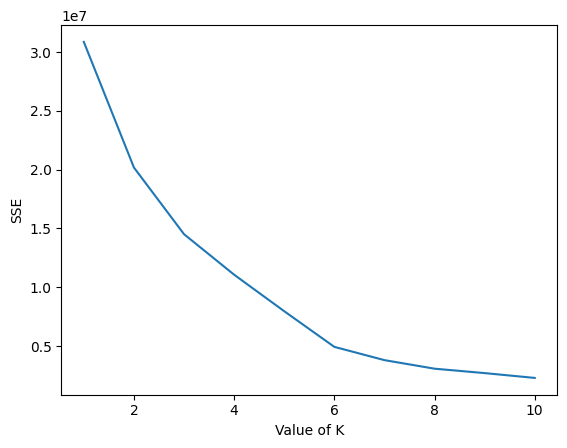

In [16]:
SSE = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state = 42)
  kmeans.fit(normalized_user)
  labels = kmeans.labels_
  score = kmeans.inertia_ #This is the SSE value
  SSE.append(score)
plt.plot(range(1,11), SSE)
plt.xlabel('Value of K')
plt.ylabel('SSE')

In [ ]:
from sklearn.manifold import TSNE
# Lets dim reduce the 16 dimension vectors to 2 dimensions to vizualise the dataset 
normalized_user_trim = normalized_user[normalized_user['count']>-0.365161]
data_embed_users = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(normalized_user_trim)


/opt/anaconda3/envs/phd/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/phd/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1154829 samples in 0.863s...


In [ ]:
#Used elbow method to choose number of cluster to be 3
kmeans = KMeans(n_clusters=6, random_state=42)
X = np.array(normalized_user)
kmeans.fit(X)
kmeans.labels_

df = pd.DataFrame(data_embed_users[:,:2],columns=["x","y"])
df['Feature 1'] = normalized_user.index
df['Feature 2'] = kmeans.labels_
df.head()
df.to_csv('DMA_rating_percent/DMA_final_cluster_users.csv', sep=',', index=False)

In [17]:
#Used elbow method to choose number of cluster to be 3
kmeans = KMeans(n_clusters=6, random_state=42)
X = np.array(normalized_user)
kmeans.fit(X)
kmeans.labels_

print(kmeans.cluster_centers_)
print(normalized_user.columns)

[[-0.39694836 -0.28080839 -0.31995812 -0.38194636  0.82795802  0.70075084
   0.55719808  0.77060435 -0.40395072 -0.15413552]
 [ 2.88447751 -0.27189326 -0.3124053  -0.41740165 -1.40319322 -2.32214882
  -2.4675911  -1.79608015 -0.4200489  -0.31179191]
 [-0.39687691 -0.27305433 -0.22452448  2.55158383 -1.16933555  0.00927201
  -0.02894918  0.10564634 -0.12535898 -0.1753545 ]
 [ 0.12745789  0.19255012  0.30073021 -0.0732126  -0.28910658 -0.3010153
   0.47490746 -1.25554522  2.21561938  1.16997594]
 [-0.3017426   4.12158222 -0.22147942 -0.40967907 -1.40276362 -1.56827326
  -1.67084087 -1.18790954 -0.29735644 -0.28444403]
 [-0.38958787 -0.27034385  3.94983824 -0.4007083  -1.40010251 -0.80809558
  -0.94100979 -0.51425053 -0.39288412 -0.29929101]]
Index(['percent1', 'percent2', 'percent3', 'percent4', 'percent5', 'mean',
       'max', 'min', 'std', 'count'],
      dtype='object')


In [18]:
df = pd.DataFrame()
df['user'] = normalized_user.index
df['cluster'] = kmeans.labels_
df.head()
df.to_csv('DMA_rating_percent/DMA_final_cluster_users.csv', sep=',', index=False)

# Can we predict rating based on clusters?

In [23]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [19]:
rating_item = rating_only.merge(df_item, left_on='item', right_on='Feature 1').rename(columns={'Feature 2':'item_cluster'})
rating_item_user = rating_item.merge(df, left_on='user', right_on='user').rename(columns={'cluster':'user_cluster'})

In [20]:
rating_item_user.head()

,item,user,rating,timestamp,x,y,Feature 1,item_cluster,user_cluster
0,0972585419,A13K4OZKAAHOXS,3.0,1190851200,-20.720667,8.847238,0972585419,1,5
1,0972585419,A1DWYEX4P7GB7Z,4.0,1188000000,-20.720667,8.847238,0972585419,1,2
2,0972585419,A3NVN97YJSKEPC,4.0,1171929600,-20.720667,8.847238,0972585419,1,2
3,0972585419,A1PDMES1LYA0DP,1.0,1483056000,-20.720667,8.847238,0972585419,1,1
4,B0002FP328,A1PDMES1LYA0DP,1.0,1483056000,5.419663,26.387459,B0002FP328,1,1


In [43]:
X = rating_item_user[['item_cluster','user_cluster']].astype(str)
y = rating_item_user[['rating']]
X_dummy = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.33, random_state=42)

In [44]:
#X_train_dummy = X_train_dummy.merge(meta_rating['rank_num','price_num']
clf = MLPClassifier(hidden_layer_sizes=(10), max_iter=100,activation = 'relu',
                     solver='lbfgs',   random_state=43)  #verbose=10,

clf.fit(X_train_dummy,y_train)

print('Accuracy on training---')
y_pred_train=clf.predict(X_train_dummy)
print(accuracy_score(y_train,y_pred_train))


print('Accuracy on test---')
y_pred_test=clf.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

Accuracy on training---
0.8008334962562704
Accuracy on test---
0.8009235671739956


In [45]:
X_test.head()

,item_cluster_0,item_cluster_1,item_cluster_2,item_cluster_3,item_cluster_4,item_cluster_5,user_cluster_0,user_cluster_1,user_cluster_2,user_cluster_3,user_cluster_4,user_cluster_5
850406,0,1,0,0,0,0,0,0,0,1,0,0
6518813,0,1,0,0,0,0,1,0,0,0,0,0
5864600,0,1,0,0,0,0,1,0,0,0,0,0
6053943,0,1,0,0,0,0,1,0,0,0,0,0
3272108,0,1,0,0,0,0,0,0,0,1,0,0


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

vect = DictVectorizer()
df_dict = X_train_dummy.to_dict('records')
df_q13 = vect.fit_transform(df_dict).toarray()
column_names = vect.get_feature_names_out()
clf = DecisionTreeClassifier(max_depth=12)
clf_fit = clf.fit(X, y)
y_pred = clf_fit.predict(X)
print(y_pred)
print(accuracy_score(y, y_pred))

[3. 4. 4. ... 1. 1. 5.]
0.8008830897993927


[Text(0.2170608108108108, 0.9545454545454546, 'item_cluster_1 <= 0.5\ngini = 0.559\nsamples = 6542483\nvalue = [641867, 372921, 516311, 845744, 4165640]'),
 Text(0.05405405405405406, 0.8636363636363636, 'item_cluster_0 <= 0.5\ngini = 0.053\nsamples = 2778279\nvalue = [0, 0, 0, 76391, 2701888]'),
 Text(0.02702702702702703, 0.7727272727272727, 'gini = 0.427\nsamples = 6435\nvalue = [0, 0, 0, 1986, 4449]'),
 Text(0.08108108108108109, 0.7727272727272727, 'item_cluster_0 <= 4.5\ngini = 0.052\nsamples = 2771844\nvalue = [0, 0, 0, 74405, 2697439]'),
 Text(0.05405405405405406, 0.6818181818181818, 'item_cluster_0 <= 1.5\ngini = 0.054\nsamples = 2625682\nvalue = [0, 0, 0, 72681, 2553001]'),
 Text(0.02702702702702703, 0.5909090909090909, 'gini = 0.054\nsamples = 2625453\nvalue = [0, 0, 0, 72652, 2552801]'),
 Text(0.08108108108108109, 0.5909090909090909, 'item_cluster_0 <= 3.5\ngini = 0.221\nsamples = 229\nvalue = [0, 0, 0, 29, 200]'),
 Text(0.05405405405405406, 0.5, 'item_cluster_0 <= 2.5\ngini =

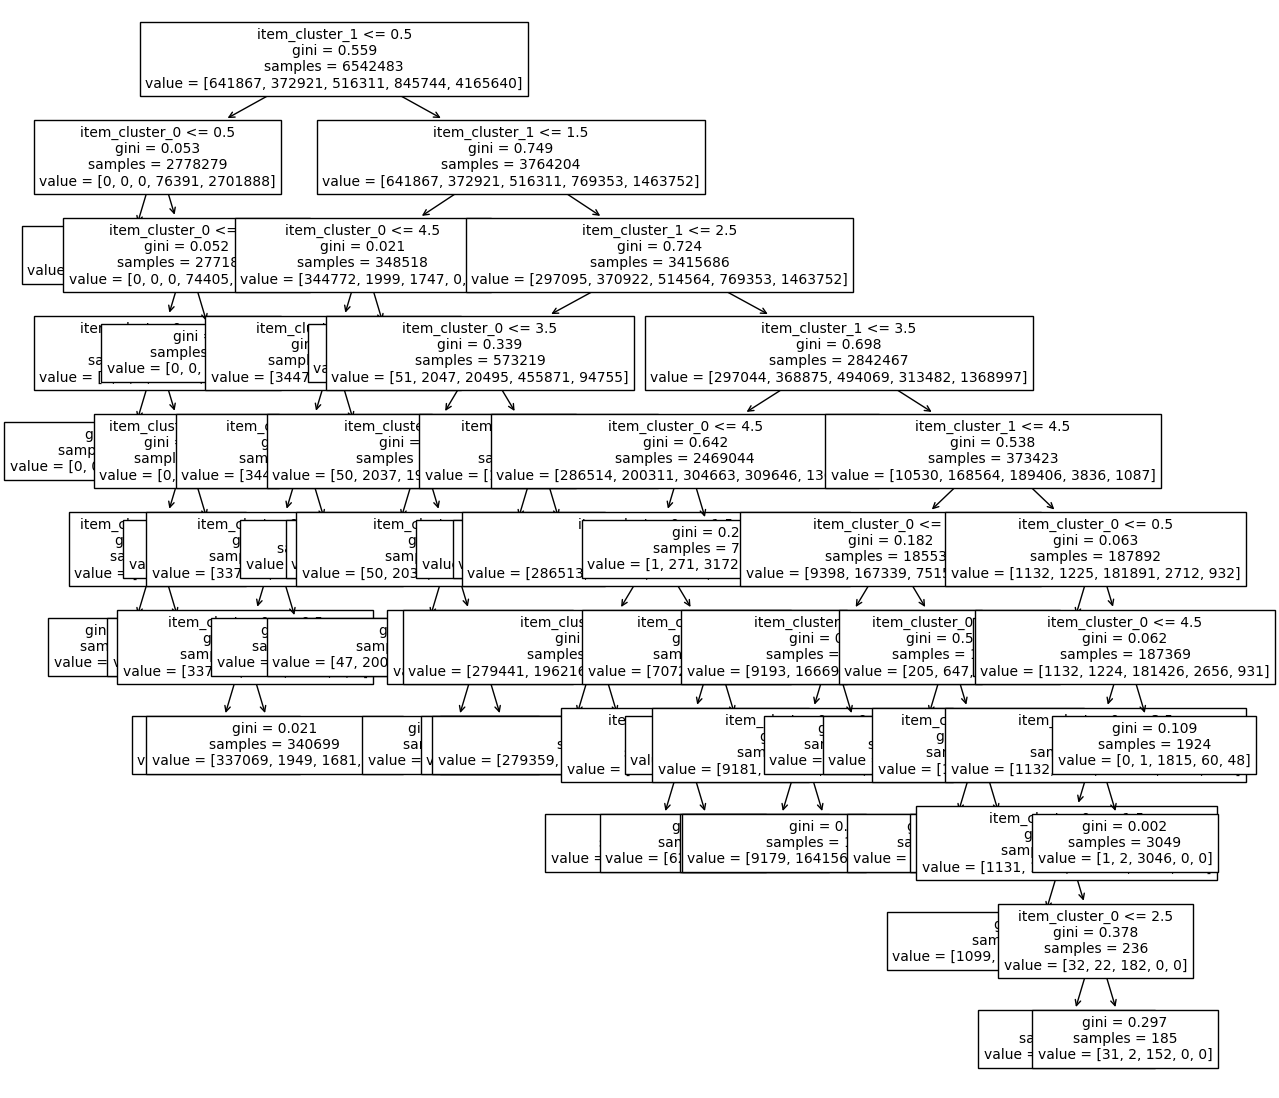

In [47]:
from sklearn import preprocessing, tree

clf = clf_fit
fig, ax = plt.subplots(figsize=(14, 14))
tree.plot_tree(clf, fontsize=10, feature_names = column_names)

In [48]:
X_train_dummy.head()

,item_cluster_0,item_cluster_1,item_cluster_2,item_cluster_3,item_cluster_4,item_cluster_5,user_cluster_0,user_cluster_1,user_cluster_2,user_cluster_3,user_cluster_4,user_cluster_5
95384,0,1,0,0,0,0,0,0,0,1,0,0
621808,0,1,0,0,0,0,0,0,0,1,0,0
5821999,0,1,0,0,0,0,1,0,0,0,0,0
3098935,0,1,0,0,0,0,0,0,0,1,0,0
3696286,0,1,0,0,0,0,0,0,1,0,0,0
